<center><h1> Smart Multidimensional Queries</h1></center>

By using the ADC, one can easily perform historical statistical analysis over an area at different time units, i.e., day, month, season or year. These statistics can be provided in the form of aggregated values for a parcel or any user-defined area. Apart from the coordinates of the area, a user can decide on additional parameters, such as the maximum cloud coverage percentage or the minimum number of cultivated crop fields over this area etc. In addition, users can easily fetch a parcel-focused Sentinel time-series for the field of inspection and decide on the validity of the farmer's declaration.

The ADC supports several services (e.g., crop classification, grassland mowing detection, SITS multidimensional statistics etc.) by providing gridded ARD. The results of these services are used to update a PostgreSQL/PostGIS database. The database contains aggregated results per parcel, which can then be easily accessed, enabling a back-and-forth communication with the ADC. Thus, PostGIS and ADC queries can be combined to address the most sophisticated of questions users might have. 

## Query 1: Generation of Feature Space

The first query enable the effortless generation of corrected, clean and smoothed Satellite Image Time-Series thsast are formed into feature spaces.

<i>Specifically, it returns monthly averages of Sentinel-1 Coherence and Sentinel-2 NDVI for Lithuania for 2020 while it applies an inward buffer of 5m.</i>

The generated feature space feed the following fl AI pipelines:
1. Grassland Mowing Detection (https://github.com/Sen4CAP)
2. Crop Classification and Smart Sampling (https://github.com/Agri-Hub/datacap)

After the execution of these algorithms, the ADC database is updated with the results for each parcel.

In [1]:
bbox = [xmin,ymin,xmax,ymax]
start_date = '2020-01-01'
end_date = '2020-12-31'
buffer = -5
optical_bands = ['ndvi']
sar_bands = ['coherence']
resampling = ['mean']
resampling_step = '30D'
output_file = 'Lithuania_2020_monthy_averages'
generate_time_series(bbox,start_date,end_date,optical_bands,sar_bands,buffer,resampling,resampling_step,output_file)

NameError: name 'xmin' is not defined

## Query 2: Selection of potential wrong declarations

<ul>
<li> List all the wrong declaration of parcels on a specific area for 2020 </li>
<li> Select a parcel to investigate (e.g. a parcel declared to cultivate maize but have been predicted in a different crop type class) </li>
<li> Select NDVI time-series with a 10-day time step during a fixed period (e.g from June to October)</li>
</ul>

### import libraries and configure datacube

In [4]:
from adc_utils import *

In [5]:
config="/home/eouser/datacube.conf"
dc = datacube.Datacube(app="test",config=config)

### Connection to db 

User connects to PostGIS db for:
1. retrieving a list of information regarding Cyprus's crops (e.g. crop id, crop code)
2. retrieving a list of information regarding wrong declaration (e.g. parcel id, geometry, declaration crop id, prediction crop id

In [6]:
import psycopg2
sql = 'SELECT * FROM crops where country = 2'
crops_cyprus = {}
try:
    connection = psycopg2.connect(database='envisiondb',host='localhost',user='postgres',password='postgres')
    cur = connection.cursor()
    cur.execute(sql)
    crops = cur.fetchall()
    for crop in crops:
        crops_cyprus[crop[0]] = crop[2]
except Exception as e:
    print("Problem:",e)

# get wrong declarations
sql = 'SELECT parcel_id,ST_AsText(geom),declared_crop_id_id,predicted_crop_id_major,prediction_confidence FROM parcels where country_id = 2 and predicted_crop_id_major > -1 and declared_crop_id_id != predicted_crop_id_major order by declared_crop_id_id desc'
try:
    connection = psycopg2.connect(database='envisiondb',host='localhost',user='postgres',password='postgres')
    cur = connection.cursor()
    cur.execute(sql)
    classification_alerts = cur.fetchall()
except Exception as e:
    print("Problem:",e)

### Show Information related to Wrong Declarations

In [7]:
headings = "Parcel ID\tDeclaration\tPrediction\tConfidence(%)"
tabs = headings.count('\t')
length = len(headings) - tabs + tabs*5
print(headings)
print(length*"=")
alerts = {}
for alert in classification_alerts:
    parcel_id,parcel_geom,declaration_id,prediction_id,confidence = alert[0],alert[1],alert[2],alert[3],alert[4]
    print("{0} \t\t {1} \t{2} \t\t{3}".format(parcel_id,crops_cyprus[declaration_id],crops_cyprus[prediction_id],confidence))
    alerts[parcel_id] = [parcel_geom]

Parcel ID	Declaration	Prediction	Confidence(%)
296980 		 Fallow 	Barley 		90.0
17173 		 Fallow 	Barley 		90.0


### User Input

In [8]:
while True:
    id_to_check = input("Enter a Parcel ID to check:")
    if id_to_check in alerts:
        break
print("Selected Parcel:{0}".format(id_to_check))

Enter a Parcel ID to check:17173
Selected Parcel:17173


### Get Data and resample to 10-days step

In [9]:
data,dates = get_data_for_validation(parcel=alerts[id_to_check],start_date='2019-01-01',end_date='2019-12-31',index='ndvi',method='median',period='month')
# ds_seasonal.ndvi.plot(col='month',col_wrap=4,cmap= 'RdYlGn')#'PuBu') #RdYlGn'
data_resampled = data.resample(time='15D').interpolate('linear')

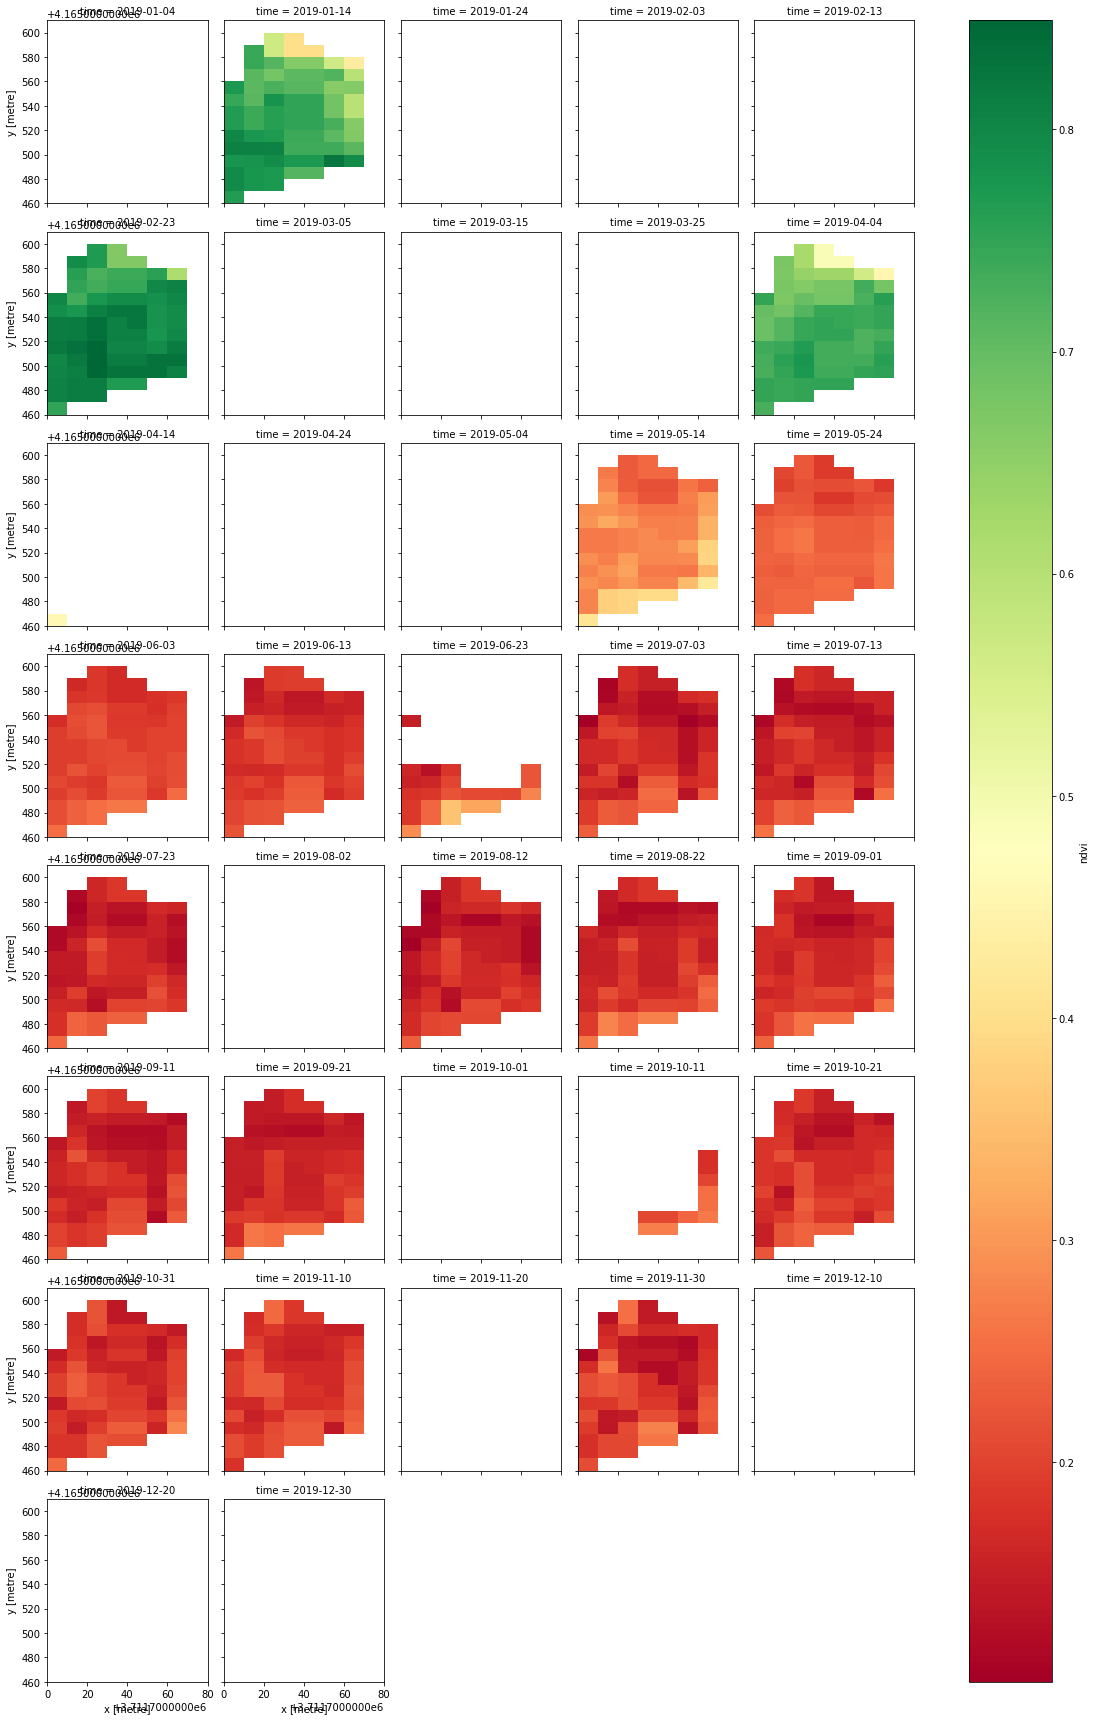

In [19]:
data_resampled.ndvi.plot(col='time',col_wrap=,cmap='RdYlGn')